# PyTorch mutual information neural estimation image-based tests

Image-based high-dimensional tests

In [1]:
import sys
sys.path.append("../python")

In [2]:
import numpy as np

In [3]:
import torch
import torchkld
import mutinfo

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda
Devices count: 2


In [5]:
from tqdm import tqdm

In [6]:
from mutinfo.distributions.base import *

In [7]:
from misc.modules import *
from misc.plots import *
from misc.utils import *

In [8]:
config = {}

## Dataset

Experimental setup

In [9]:
config["mutual_information"] = 10.0

config["dataset_type"] = "gaussians"
assert config["dataset_type"] in ["rectangles", "gaussians"]

config["min_delta"] = 0.2 # Minimum (normalized) width/height for rectangles to avoid singularity.

In [10]:
config["image_width"]  = 16
config["image_height"] = 16

In [11]:
from mutinfo.distributions.tools import mapped_multi_rv_frozen
from mutinfo.distributions.images.geometric import uniform_to_rectangle, draw_rectangle
from mutinfo.distributions.images.field import draw_field, symmetric_gaussian_field

if config["dataset_type"] == "rectangles":
    config["X_latent_dimension"] = 4
    config["Y_latent_dimension"] = 4

    def generation_mapping(x, y):
        x = draw_rectangle(uniform_to_rectangle(ndtr(x), config["min_delta"], config["min_delta"]), config["image_width"], config["image_height"])
        y = draw_rectangle(uniform_to_rectangle(ndtr(y), config["min_delta"], config["min_delta"]), config["image_width"], config["image_height"])
        
        return x, y

    random_variable = mapped_multi_rv_frozen(
        CorrelatedNormal(config["mutual_information"], config["X_latent_dimension"], config["Y_latent_dimension"], randomize_interactions=False),
        generation_mapping
    )
    
elif config["dataset_type"] == "gaussians":
    config["X_latent_dimension"] = 2
    config["Y_latent_dimension"] = 2

    def generation_mapping(x, y):
        x = draw_field(ndtr(x), symmetric_gaussian_field, (config["image_width"], config["image_height"]))
        y = draw_field(ndtr(y), symmetric_gaussian_field, (config["image_width"], config["image_height"]))
        
        return x, y

    random_variable = mapped_multi_rv_frozen(
        CorrelatedNormal(config["mutual_information"], config["X_latent_dimension"], config["Y_latent_dimension"], randomize_interactions=False),
        generation_mapping
    )

In [12]:
config["n_samples"] = 10*1024
x, y = random_variable.rvs(config["n_samples"])

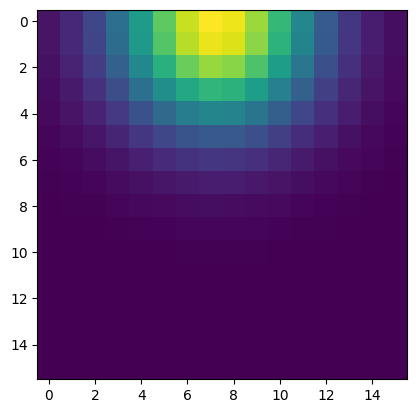

In [13]:
plt.imshow(random_variable.rvs(10)[0][0])

## Estimating MI

Dataset and dataloader

In [14]:
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(x, dtype=torch.float32)[:,None,...],
    torch.tensor(y, dtype=torch.float32)[:,None,...],
)

x, y = random_variable.rvs(config["n_samples"])
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(x, dtype=torch.float32)[:,None,...],
    torch.tensor(y, dtype=torch.float32)[:,None,...],
)

In [15]:
config["batch_size"] = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset,  batch_size=config["batch_size"], shuffle=False)

Model

In [16]:
n_filters = 8
hidden_dimension = 128

model = BasicConv2dT(config["image_width"], config["image_width"], n_filters=n_filters, hidden_dimension=hidden_dimension).to(device)
total_parameters = sum(parameter.numel() for parameter in model.parameters())
print(f"Total parameters: {total_parameters}")

Total parameters: 50865


In [17]:
config["n_parameters"] = total_parameters

Loss

In [18]:
# Loss.
config["biased"] = False
config["ema_multiplier"] = 1.0e-2
config["marginalize"] = "product" # "permute", "product"

losses = {
    "DonskerVaradhan": torchkld.loss.DonskerVaradhanLoss(biased=config["biased"], ema_multiplier=config["ema_multiplier"]),
    "NWJ": torchkld.loss.NWJLoss(),
    "Nishiyama": torchkld.loss.NishiyamaLoss(),
    "InfoNCE": torchkld.loss.InfoNCELoss(),
}

config["loss_name"] = "InfoNCE"
loss = losses[config["loss_name"]]

Optimizer

In [19]:
config["learning_rate"] = 1.0e-3
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

Training

In [20]:
import matplotlib
from matplotlib import pyplot as plt

In [21]:
# Total number of epochs.
config["n_epochs"] = 100

# Number of epochs used to average the estimate.
config["average_epochs"] = 20

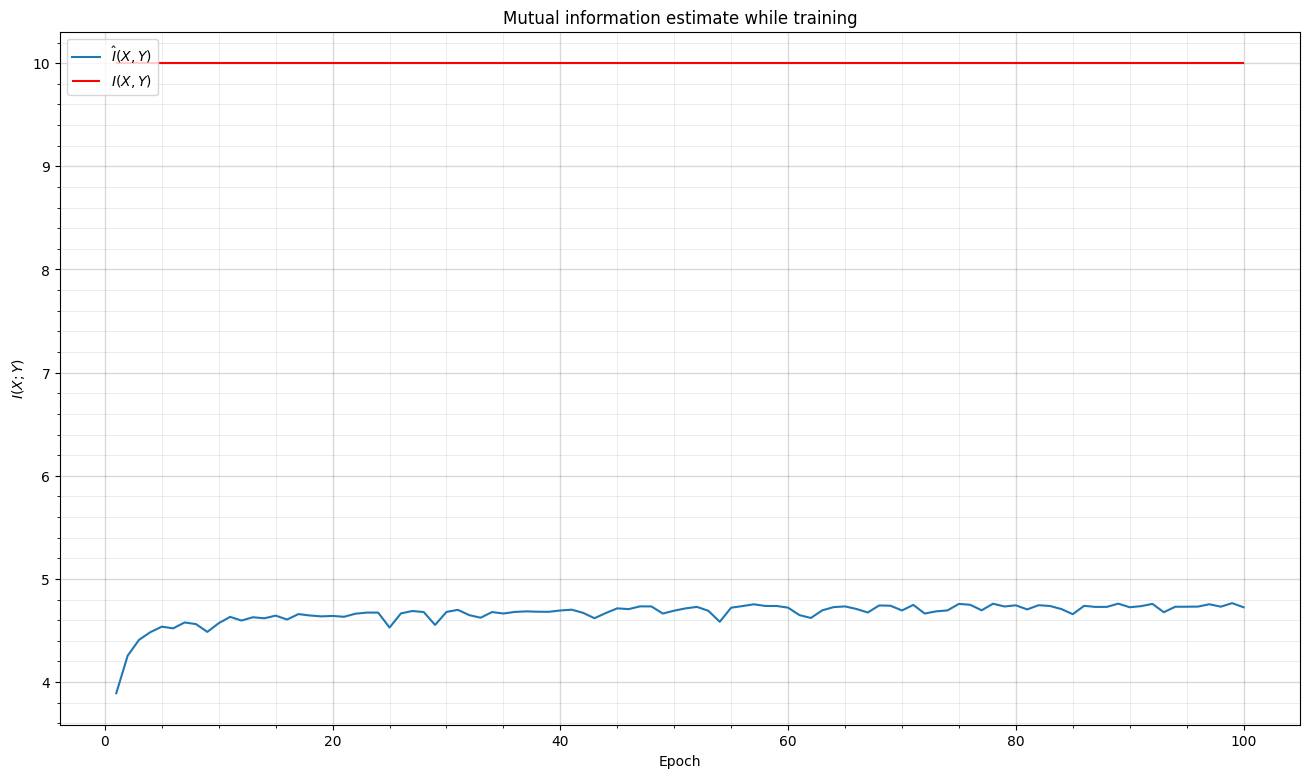

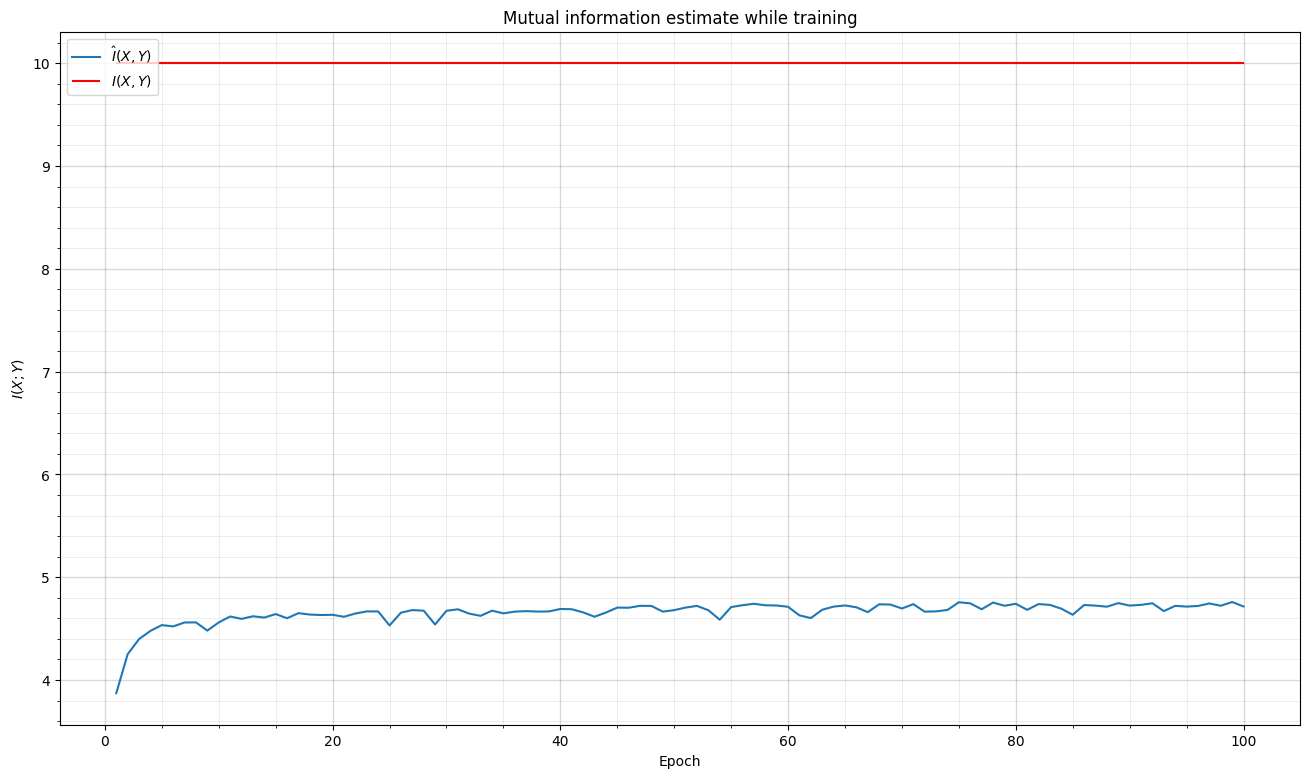

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:27<00:00,  2.68s/it]

Current estimate: 4.716
Running median: 4.723


In [22]:
from collections import defaultdict
from IPython.display import clear_output
from tqdm import trange

history = defaultdict(list)
for epoch in trange(1, config["n_epochs"] + 1, mininterval=1):    
    # Training.
    for index, batch in enumerate(train_dataloader):
        x, y = batch
        batch_size = x.shape[0]

        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        T_joined   = model(x.to(device), y.to(device))
        T_marginal = model(x.to(device), y.to(device), marginalize=config["marginalize"])
        _loss = loss(T_joined, T_marginal)
        _loss.backward()
        
        optimizer.step()

    history["train_mutual_information"].append(
        model.get_mutual_information(
            train_dataloader,
            loss,
            device,
            marginalize=config["marginalize"],
        )
    )
    history["test_mutual_information"].append(
        model.get_mutual_information(
            test_dataloader,
            loss,
            device,
            marginalize=config["marginalize"],
        )
    )

    if epoch % 5 == 0:        
        clear_output(wait=True)
        plot_estimated_MI_trainig(config["mutual_information"], np.arange(1, epoch+1), history["train_mutual_information"])
        plot_estimated_MI_trainig(config["mutual_information"], np.arange(1, epoch+1), history["test_mutual_information"])
        print(f"Current estimate: {history['test_mutual_information'][-1]:.3f}")
        print(f"Running median: {np.median(history['test_mutual_information'][-config['average_epochs']:]):.3f}")

### Saving the results

In [23]:
config

{'mutual_information': 10.0,
 'dataset_type': 'gaussians',
 'min_delta': 0.2,
 'image_width': 16,
 'image_height': 16,
 'X_latent_dimension': 2,
 'Y_latent_dimension': 2,
 'n_samples': 10240,
 'batch_size': 128,
 'n_parameters': 50865,
 'biased': False,
 'ema_multiplier': 0.01,
 'marginalize': 'product',
 'loss_name': 'InfoNCE',
 'learning_rate': 0.001,
 'n_epochs': 100,
 'average_epochs': 20}

In [24]:
from datetime import datetime

experiment_name = f"{config['dataset_type']}_{config['image_width']}x{config['image_height']}_{config['mutual_information']:.1f}_{config['n_samples']}__{datetime.now().strftime('%d-%b-%Y_%H:%M:%S')}"
print(experiment_name)

gaussians_16x16_10.0_10240__27-Jan-2025_16:58:05


In [25]:
import os
from pathlib import Path

data_path = Path(os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), "../../data/synthetic")))
experiment_path = data_path / f"{config['dataset_type']}_{config['image_width']}x{config['image_height']}" / config['loss_name'] / experiment_name

In [26]:
save_results(history, config, experiment_path, average_epochs=config['average_epochs'])